In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [28]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [ ]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Datasets',
#     shuffle = True,
#     image_size = (IMAGE_SIZE, IMAGE_SIZE),
#     batch_size = BATCH_SIZE
# )

In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\Python\Data Science\Road Damage\pothole_detection_CNN\Data_aug',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 10155 files belonging to 3 classes.


In [30]:
class_names = dataset.class_names
class_names

['crack_aug', 'pothole_aug', 'surface_erosion_aug']

In [31]:
len(dataset)

318

In [32]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 1 1 2 0 2 2 2 2 0 2 2 2 1 2 0 0 0 1 2 1 0 2 1 0 0 2 2 1 2 0]


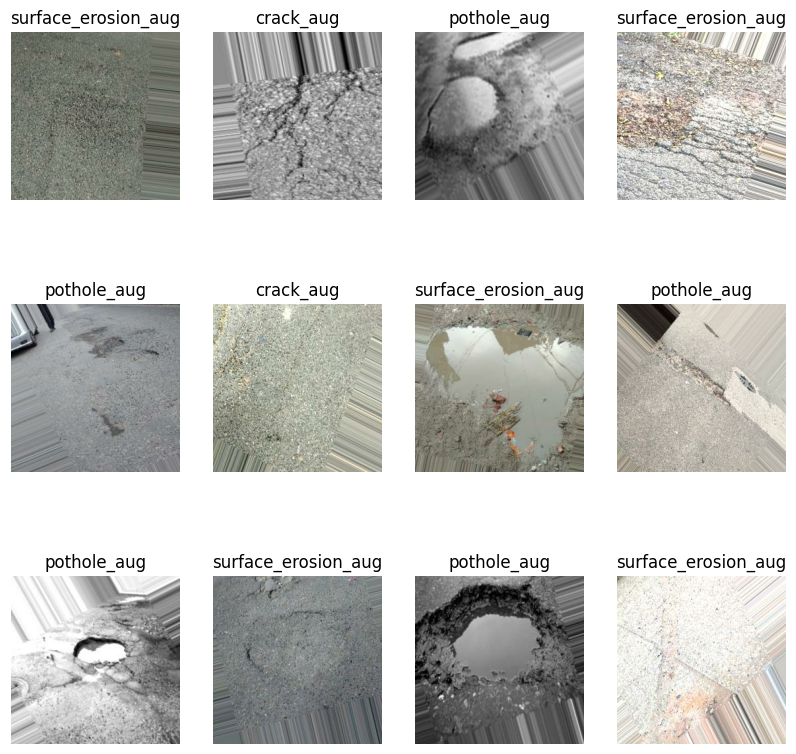

In [33]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [34]:

def partition_data(dataset, train_size=0.8, validation_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_size = int(total_size * train_size)
    validation_size = int(total_size * validation_size)
    test_size = int(total_size * test_size)

    # Split the data into training, validation, and test datasets
    train_data = dataset.take(train_size)
    remaining_data = dataset.skip(train_size)
    
    validation_data = remaining_data.take(validation_size)
    test_data = remaining_data.skip(validation_size)
    
    return train_data, validation_data, test_data


# Example usage:

# Assuming `dataset` is a tf.data.Dataset object
train_data, validation_data, test_data = partition_data(dataset)

# Check the lengths of each dataset
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")


Training data size: 254
Validation data size: 31
Test data size: 33


In [35]:
train_data, validation_data, test_data = partition_data(dataset)

In [36]:
len(train_data)
len(validation_data)
len(test_data)

33

In [37]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [38]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [39]:
def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        #data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [ ]:
model = build_mobilenet_model()

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

In [ ]:
scores = model.evaluate(test_data)
scores

In [ ]:
model.save("Trained Model/CNN.h5")

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
history.history['accuracy']

In [ ]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [ ]:
model.evaluate(test_data)

In [ ]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

In [ ]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [ ]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get true and predicted labels
y_true = []
y_pred = []

# Loop through test dataset
for images, labels in test_data:
    predictions = model.predict(images)
    
    y_true.extend(labels.numpy())  # Use labels directly
    y_pred.extend(np.argmax(predictions, axis=1))


# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Optional: If you want custom class names
class_names = ['Crack', 'Pothole', 'Surface Erosion']  # Replace with your actual class names

# Step 3: Plot and save the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size if needed
disp.plot(ax=ax, cmap=plt.cm.Blues)

# Save as image
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Optional: define class names based on your dataset
class_names = ['Crack', 'Pothole', 'Surface Erosion']  # Update if you have different classes

# Step 1: Get true and predicted labels
y_true = []
y_pred = []

# Loop through test dataset
for images, labels in test_data:
    predictions = model.predict(images)
    
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Normalize the confusion matrix (row-wise normalization)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Step 4: Plot the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")  # 2 decimal places

# Step 5: Save and show the plot
plt.title("build_VGG19_model")
plt.savefig("confusion_matrix_normalized.png", dpi=300, bbox_inches='tight')
plt.show()
